In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tqdm.notebook import tqdm
from datetime import datetime

# Set seeds for reproducibility
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

print("Libraries imported successfully")

Libraries imported successfully


Loaded DTW similarity matrix with 246 POCs
Matrix shape: (246, 246)
First 5 POC IDs: ['ABY0111', 'ALB0331', 'ALB1101', 'APS0111', 'ARA2201']


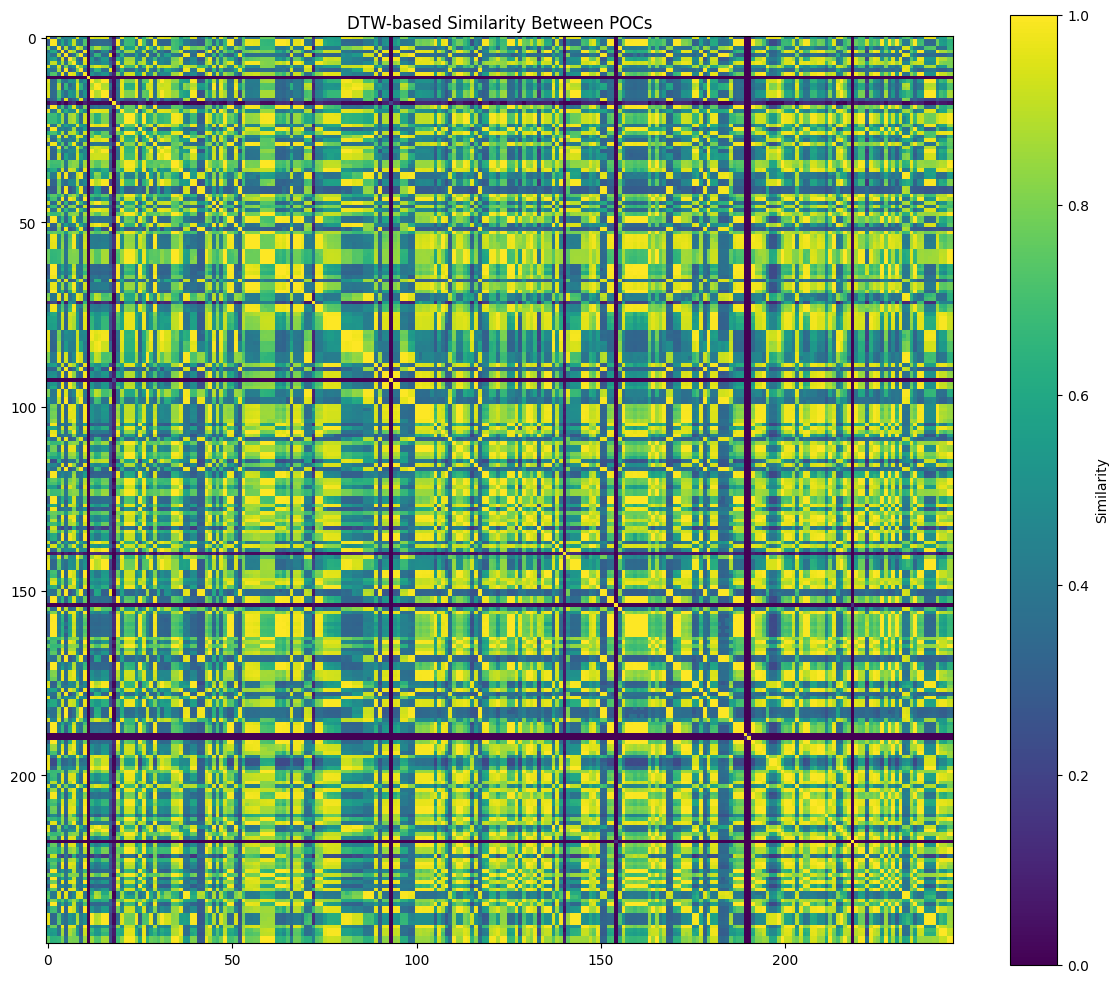

In [ ]:
def load_dtw_matrix(file_path='/content/drive/MyDrive/WattGrid/data/processed/dtw_adjacency2_matrix.csv'):
    """
    Load pre-computed DTW similarity matrix
    """
    try:
        # Load matrix from CSV file
        similarity_df = pd.read_csv(file_path, index_col=0)

        # Extract POC IDs from index
        poc_ids = similarity_df.index.tolist()

        # Convert to numpy array
        similarity_matrix = similarity_df.values

        print(f"Loaded DTW similarity matrix with {len(poc_ids)} POCs")
        print(f"Matrix shape: {similarity_matrix.shape}")
        print(f"First 5 POC IDs: {poc_ids[:5]}")

        return similarity_matrix, poc_ids
    except Exception as e:
        print(f"Error loading DTW matrix: {e}")
        return None, None

# Load the DTW matrix
similarity_matrix, poc_ids = load_dtw_matrix('/content/drive/MyDrive/WattGrid/data/processed/dtw_adjacency2_matrix.csv')

# Visualize the similarity matrix
if similarity_matrix is not None:
    plt.figure(figsize=(12, 10))
    plt.imshow(similarity_matrix, cmap='viridis')
    plt.colorbar(label='Similarity')
    plt.title('DTW-based Similarity Between POCs')
    plt.tight_layout()
    plt.show()
else:
    print("Could not visualize similarity matrix due to loading error")

In [ ]:
def create_graph_from_similarity(similarity_matrix, threshold=0.7):
    """
    Create graph structure from similarity matrix using threshold
    """
    if similarity_matrix is None:
        print("No similarity matrix provided")
        return None, None, None

    # Create binary adjacency matrix
    adjacency_matrix = (similarity_matrix >= threshold).astype(np.float32)

    # Add self-loops (each node connected to itself)
    np.fill_diagonal(adjacency_matrix, 1.0)

    # Create edge_index for PyTorch Geometric
    edge_index = []
    edge_weight = []

    for i in range(adjacency_matrix.shape[0]):
        for j in range(adjacency_matrix.shape[1]):
            if adjacency_matrix[i, j] > 0:
                edge_index.append([i, j])
                edge_weight.append(similarity_matrix[i, j])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t()
    edge_weight = torch.tensor(edge_weight, dtype=torch.float)

    return adjacency_matrix, edge_index, edge_weight

# Test different thresholds to find appropriate graph density
thresholds = [0.9, 0.8, 0.7, 0.6, 0.5]
metrics = []

for threshold in thresholds:
    adj_matrix, edge_index, edge_weight = create_graph_from_similarity(similarity_matrix, threshold)
    if adj_matrix is not None:
        avg_connections = adj_matrix.sum() / len(adj_matrix)
        percent_connections = avg_connections / len(adj_matrix) * 100
        metrics.append({
            'threshold': threshold,
            'avg_connections': avg_connections,
            'percent_connections': percent_connections,
            'num_edges': edge_index.shape[1] if edge_index is not None else 0
        })
        print(f"Threshold {threshold}: Avg connections = {avg_connections:.2f} ({percent_connections:.1f}%)")

# Select optimal threshold (choose threshold that gives reasonable connectivity)
optimal_threshold = 0.7  # Adjusted based on output
adjacency_matrix, edge_index, edge_weight = create_graph_from_similarity(similarity_matrix, optimal_threshold)

if adjacency_matrix is not None:
    print(f"\nSelected threshold {optimal_threshold}")
    print(f"Graph has {edge_index.shape[1]} edges")
    print(f"Average connections per node: {adjacency_matrix.sum() / len(adjacency_matrix):.2f}")

Threshold 0.9: Avg connections = 56.41 (22.9%)
Threshold 0.8: Avg connections = 85.26 (34.7%)
Threshold 0.7: Avg connections = 107.91 (43.9%)
Threshold 0.6: Avg connections = 127.40 (51.8%)
Threshold 0.5: Avg connections = 146.05 (59.4%)

Selected threshold 0.7
Graph has 26546 edges
Average connections per node: 107.91


Loading featured data from /content/drive/MyDrive/WattGrid/data/processed/featured_data.csv
Loaded sample of 100000 rows
Dataset spans from 2022-11-04 00:00:00 to 2022-12-30 00:00:00
Number of unique POCs: 241

Price statistics:
count    100000.000000
mean         10.214529
std          24.112859
min           0.000000
25%           0.030000
50%           0.480000
75%           9.190000
max         225.820000
Name: DollarsPerMegawattHour, dtype: float64


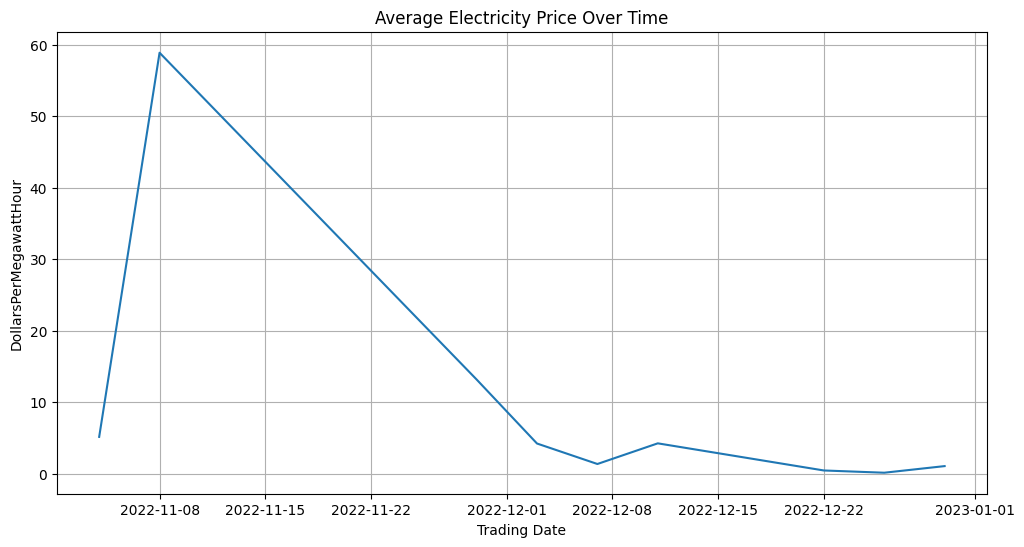

Extracting rich node features...
Using features: ['DollarsPerMegawattHour', 'RollingMean_7', 'RollingStd_7', 'Lag_1', 'Lag_7', 'PriceVolatility']
No data found for POC HRP2201 on latest date
No data found for POC NWD0661 on latest date
No data found for POC TAB0331 on latest date
No data found for POC TAB2201 on latest date
No data found for POC WAI0331 on latest date
Extracted features for 241 POCs out of 246
Node features matrix shape: torch.Size([241, 8])
Creating target values...
Created targets for 241 POCs
Target range: 0.8783 to 1.1336
Target mean: 1.0000, std: 0.0552


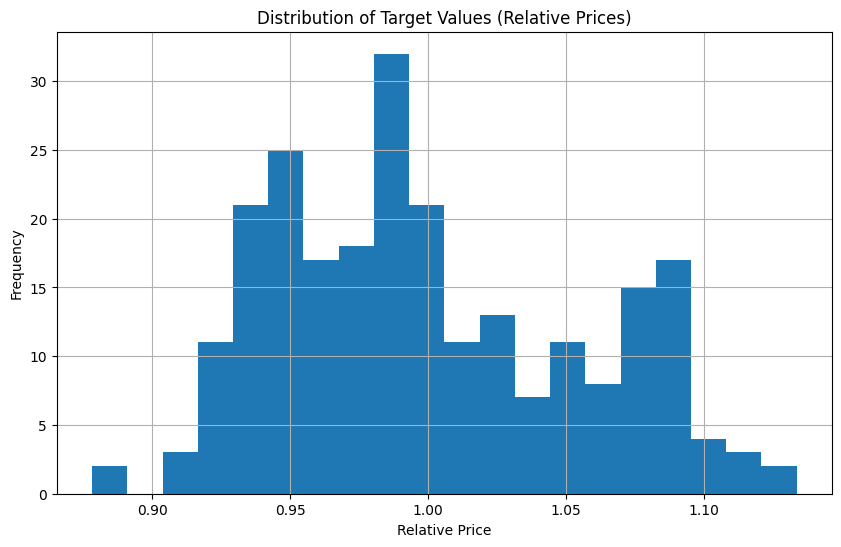

In [ ]:
def load_featured_data(file_path='/content/drive/MyDrive/WattGrid/data/processed/featured_data.csv', nrows=None):
    """
    Load the featured dataset with electricity price data
    """
    try:
        print(f"Loading featured data from {file_path}")
        # Load full dataset or sample based on nrows parameter
        if nrows:
            featured_data = pd.read_csv(file_path, nrows=nrows)
            print(f"Loaded sample of {len(featured_data)} rows")
        else:
            featured_data = pd.read_csv(file_path)
            print(f"Loaded complete dataset with {len(featured_data)} rows")

        # Convert date columns to datetime
        if 'TradingDate' in featured_data.columns:
            featured_data['TradingDate'] = pd.to_datetime(featured_data['TradingDate'])

        if 'PublishDateTime' in featured_data.columns:
            featured_data['PublishDateTime'] = pd.to_datetime(featured_data['PublishDateTime'])

        # Show basic info
        print(f"Dataset spans from {featured_data['TradingDate'].min()} to {featured_data['TradingDate'].max()}")
        print(f"Number of unique POCs: {featured_data['PointOfConnection'].nunique()}")

        # Show price statistics
        if 'DollarsPerMegawattHour' in featured_data.columns:
            print("\nPrice statistics:")
            price_stats = featured_data['DollarsPerMegawattHour'].describe()
            print(price_stats)

            # Show price range over time
            price_over_time = featured_data.groupby('TradingDate')['DollarsPerMegawattHour'].mean()
            plt.figure(figsize=(12, 6))
            plt.plot(price_over_time.index, price_over_time.values)
            plt.title('Average Electricity Price Over Time')
            plt.xlabel('Trading Date')
            plt.ylabel('DollarsPerMegawattHour')
            plt.grid(True)
            plt.show()

        return featured_data
    except Exception as e:
        print(f"Error loading featured data: {e}")
        return None

# Load the featured data
featured_data = load_featured_data('/content/drive/MyDrive/WattGrid/data/processed/featured_data.csv', nrows=100000)

# Extract rich node features from featured data
def extract_rich_node_features(featured_data, poc_ids):
    """
    Extract rich node features from the featured data
    """
    if featured_data is None or poc_ids is None:
        print("Missing data for feature extraction")
        return None, None

    print("Extracting rich node features...")

    # Get the latest data for each POC
    latest_date = featured_data['TradingDate'].max()

    # Features to extract
    feature_columns = [
        'DollarsPerMegawattHour', 'RollingMean_7', 'RollingStd_7',
        'Lag_1', 'Lag_7', 'PriceVolatility'
    ]

    # Check which features are available
    available_features = [col for col in feature_columns if col in featured_data.columns]
    print(f"Using features: {available_features}")

    # Create node features for each POC in similarity matrix
    node_features = []
    valid_poc_ids = []

    for i, poc_id in enumerate(poc_ids):
        # Get data for this POC from the latest date
        poc_data = featured_data[(featured_data['PointOfConnection'] == poc_id) &
                                (featured_data['TradingDate'] == latest_date)]

        if len(poc_data) > 0:
            # Take the most recent trading period
            latest_period = poc_data['TradingPeriod'].max()
            latest_row = poc_data[poc_data['TradingPeriod'] == latest_period].iloc[0]

            # Extract features
            features = []
            for feature in available_features:
                features.append(latest_row[feature])

            # Add island as one-hot feature if available
            if 'Island' in featured_data.columns:
                islands = featured_data['Island'].unique()
                for island in islands:
                    features.append(1.0 if latest_row['Island'] == island else 0.0)

            # Convert to tensor and append
            node_features.append(torch.tensor(features, dtype=torch.float))
            valid_poc_ids.append(poc_id)
        else:
            print(f"No data found for POC {poc_id} on latest date")

    print(f"Extracted features for {len(valid_poc_ids)} POCs out of {len(poc_ids)}")

    if not node_features:
        print("No valid node features extracted")
        return None, None

    # Stack features into a matrix
    node_features_matrix = torch.stack(node_features)
    print(f"Node features matrix shape: {node_features_matrix.shape}")

    # Normalize features for stability
    node_means = node_features_matrix.mean(dim=0)
    node_stds = node_features_matrix.std(dim=0)
    node_stds[node_stds == 0] = 1.0  # Avoid division by zero
    node_features_matrix = (node_features_matrix - node_means) / node_stds

    return node_features_matrix, valid_poc_ids

# Extract node features from the featured data
node_features_matrix, valid_poc_ids = extract_rich_node_features(featured_data, poc_ids)

# Create meaningful target values
def create_meaningful_targets(featured_data, valid_poc_ids):
    """
    Create meaningful target values representing relative price differences
    """
    if featured_data is None or not valid_poc_ids:
        print("Missing data for target creation")
        return None

    print("Creating target values...")

    # Get future trading period data
    latest_date = featured_data['TradingDate'].max()

    # Find all trading periods
    all_periods = sorted(featured_data['TradingPeriod'].unique())

    # For each POC, use the relative price compared to the market average
    target_values = []
    valid_poc_indices = []

    # Calculate market average price for reference
    latest_data = featured_data[featured_data['TradingDate'] == latest_date]
    market_avg = latest_data['DollarsPerMegawattHour'].mean()

    for i, poc_id in enumerate(valid_poc_ids):
        # Get data for this POC
        poc_data = featured_data[(featured_data['PointOfConnection'] == poc_id) &
                               (featured_data['TradingDate'] == latest_date)]

        if len(poc_data) > 0:
            # Use relative price to market average
            avg_price = poc_data['DollarsPerMegawattHour'].mean()
            relative_price = avg_price / market_avg if market_avg > 0 else 1.0

            # Ensure we have variation in targets
            target_values.append([relative_price])
            valid_poc_indices.append(i)

    if not target_values:
        print("Could not create any valid targets")
        return None, None

    # Convert to tensor
    target_tensor = torch.tensor(target_values, dtype=torch.float)

    print(f"Created targets for {len(target_values)} POCs")
    print(f"Target range: {target_tensor.min().item():.4f} to {target_tensor.max().item():.4f}")
    print(f"Target mean: {target_tensor.mean().item():.4f}, std: {target_tensor.std().item():.4f}")

    # Visualize target distribution
    plt.figure(figsize=(10, 6))
    plt.hist(target_tensor.numpy(), bins=20)
    plt.title('Distribution of Target Values (Relative Prices)')
    plt.xlabel('Relative Price')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    return target_tensor, valid_poc_indices

# Create target values
target_values, valid_indices = create_meaningful_targets(featured_data, valid_poc_ids)

Created subgraph with 241 nodes and 25177 edges


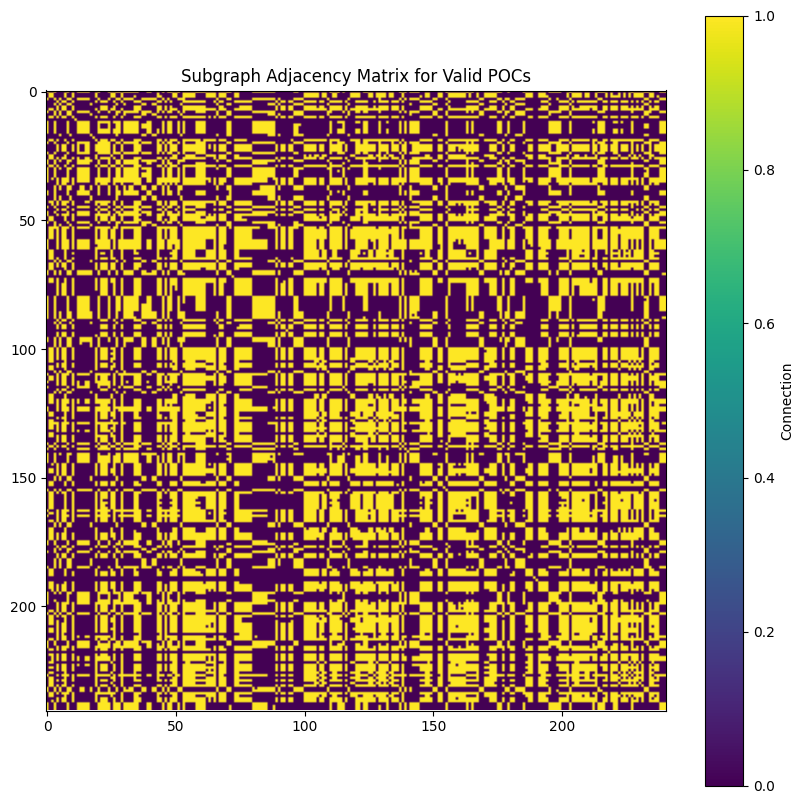

In [ ]:
def create_subgraph(adjacency_matrix, edge_index, edge_weight, valid_indices):
    """
    Create a subgraph with only the valid nodes
    """
    if adjacency_matrix is None or edge_index is None or not valid_indices:
        print("Missing data for subgraph creation")
        return None, None, None

    try:
        # Create a mapping from original indices to new indices
        old_to_new = {old_idx: new_idx for new_idx, old_idx in enumerate(valid_indices)}

        # Extract the submatrix from the adjacency matrix
        sub_adjacency = adjacency_matrix[np.ix_(valid_indices, valid_indices)]

        # Create new edge_index and edge_weight for valid nodes only
        new_edge_index = []
        new_edge_weight = []

        for i, (src, dst) in enumerate(edge_index.t().tolist()):
            if src in valid_indices and dst in valid_indices:
                new_edge_index.append([old_to_new[src], old_to_new[dst]])
                new_edge_weight.append(edge_weight[i].item())

        new_edge_index = torch.tensor(new_edge_index, dtype=torch.long).t()
        new_edge_weight = torch.tensor(new_edge_weight, dtype=torch.float)

        print(f"Created subgraph with {len(valid_indices)} nodes and {new_edge_index.shape[1]} edges")

        return sub_adjacency, new_edge_index, new_edge_weight
    except Exception as e:
        print(f"Error creating subgraph: {e}")
        return None, None, None

# Create subgraph for valid nodes
sub_adjacency, sub_edge_index, sub_edge_weight = create_subgraph(
    adjacency_matrix, edge_index, edge_weight, valid_indices)

# Visualize the subgraph
if sub_adjacency is not None:
    plt.figure(figsize=(10, 10))
    plt.imshow(sub_adjacency, cmap='viridis')
    plt.colorbar(label='Connection')
    plt.title('Subgraph Adjacency Matrix for Valid POCs')
    plt.show()

In [ ]:
class GATNet(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_heads=2, dropout=0.2):
        super().__init__()
        # Input normalization for numerical stability
        self.input_norm = nn.LayerNorm(in_channels)

        # First GAT layer with attention heads
        self.gat1 = GATConv(in_channels, hidden_channels, heads=num_heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(hidden_channels * num_heads)

        # Second GAT layer
        self.gat2 = GATConv(hidden_channels * num_heads, hidden_channels, heads=1, dropout=dropout)
        self.norm2 = nn.LayerNorm(hidden_channels)

        # Output prediction layer
        self.output = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, edge_weight=None):
        # Normalize input
        x = self.input_norm(x)

        # First GAT layer with ReLU and normalization
        x = self.gat1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.norm1(x)
        x = F.dropout(x, p=0.2, training=self.training)

        # Second GAT layer
        x = self.gat2(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.norm2(x)

        # Output prediction
        x = self.output(x)

        return x

    def get_attention_weights(self, x, edge_index, edge_weight=None):
        """Get attention weights for interpretability"""
        x = self.input_norm(x)
        _, attn_weights = self.gat1(x, edge_index, edge_weight, return_attention_weights=True)
        return attn_weights

print("GAT model defined successfully")

GAT model defined successfully


In [ ]:
def train_gat_model(model, node_features, edge_index, edge_weight, targets, epochs=100, lr=0.01):
    """
    Train the GAT model with error handling
    """
    if model is None or node_features is None or edge_index is None or targets is None:
        print("Missing data for training")
        return None, None

    try:
        model.train()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
        criterion = nn.MSELoss()

        # Move everything to device
        device = next(model.parameters()).device
        node_features = node_features.to(device)
        edge_index = edge_index.to(device)
        edge_weight = edge_weight.to(device)
        targets = targets.to(device)

        # Early stopping parameters
        best_loss = float('inf')
        patience = 15
        counter = 0
        best_model_state = None

        losses = []

        for epoch in tqdm(range(epochs), desc="Training GAT"):
            optimizer.zero_grad()

            # Forward pass
            out = model(node_features, edge_index, edge_weight)

            # Calculate loss
            loss = criterion(out, targets)

            # Backward pass
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

            losses.append(loss.item())

            # Early stopping check
            if loss.item() < best_loss:
                best_loss = loss.item()
                counter = 0
                best_model_state = model.state_dict().copy()
            else:
                counter += 1
                if counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    if best_model_state is not None:
                        model.load_state_dict(best_model_state)
                    break

            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

        # Ensure best model is loaded
        if best_model_state is not None:
            model.load_state_dict(best_model_state)

        # Plot loss curve
        plt.figure(figsize=(10, 6))
        plt.plot(losses)
        plt.title('GAT Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.show()

        return losses, model
    except Exception as e:
        print(f"Error during training: {e}")
        return None, None

print("Training function defined successfully")

Training function defined successfully


Using device: cpu
GATNet(
  (input_norm): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
  (gat1): GATConv(8, 16, heads=2)
  (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (gat2): GATConv(32, 16, heads=1)
  (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  (output): Linear(in_features=16, out_features=1, bias=True)
)
Number of parameters: 1041


Training GAT:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 10/100, Loss: 0.026733
Epoch 20/100, Loss: 0.008349
Epoch 30/100, Loss: 0.005874
Epoch 40/100, Loss: 0.006409
Epoch 50/100, Loss: 0.003714
Early stopping at epoch 59


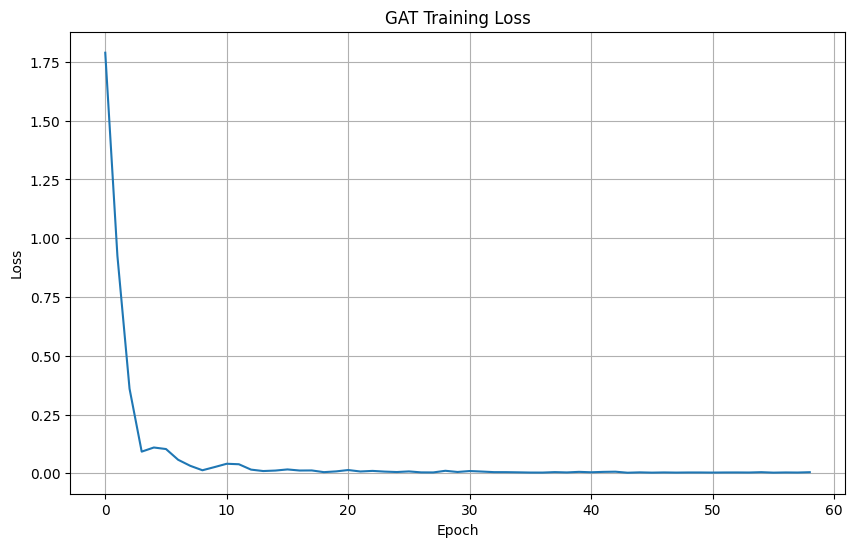

Model training completed successfully


In [ ]:
# Check if all required components are available
if (node_features_matrix is not None and sub_edge_index is not None and
    sub_edge_weight is not None and target_values is not None):

    # Define model parameters
    in_channels = node_features_matrix.shape[1]  # Number of feature dimensions
    hidden_channels = 16                         # Hidden dimension size
    out_channels = 1                             # Predicting a single value
    num_heads = 2                                # Number of attention heads
    dropout = 0.2                                # Dropout rate

    # Choose device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize the GAT model
    gat_model = GATNet(in_channels, hidden_channels, out_channels, num_heads, dropout).to(device)

    # Print model summary
    print(gat_model)
    print(f"Number of parameters: {sum(p.numel() for p in gat_model.parameters())}")

    # Train the model
    losses, gat_model = train_gat_model(
        model=gat_model,
        node_features=node_features_matrix,
        edge_index=sub_edge_index,
        edge_weight=sub_edge_weight,
        targets=target_values,
        epochs=100,
        lr=0.005
    )

    if losses is not None:
        print("Model training completed successfully")
    else:
        print("Model training failed")
else:
    print("Cannot train model: missing input data")
    if node_features_matrix is None:
        print("- Node features matrix is missing")
    if sub_edge_index is None:
        print("- Edge index is missing")
    if sub_edge_weight is None:
        print("- Edge weights are missing")
    if target_values is None:
        print("- Target values are missing")

In [ ]:
def evaluate_gat_model(model, node_features, edge_index, edge_weight, targets):
    """
    Evaluate the trained GAT model with detailed metrics
    """
    if model is None or node_features is None or edge_index is None or targets is None:
        print("Missing data for evaluation")
        return None, None, None

    try:
        model.eval()
        device = next(model.parameters()).device

        # Move data to device
        node_features = node_features.to(device)
        edge_index = edge_index.to(device)
        edge_weight = edge_weight.to(device)
        targets = targets.to(device)

        with torch.no_grad():
            predictions = model(node_features, edge_index, edge_weight)

            # Calculate metrics
            mse = F.mse_loss(predictions, targets).item()
            rmse = np.sqrt(mse)
            mae = F.l1_loss(predictions, targets).item()

            # Move to CPU for numpy calculations
            predictions_np = predictions.cpu().numpy().flatten()
            targets_np = targets.cpu().numpy().flatten()

            # Calculate correlation coefficient
            correlation = np.corrcoef(predictions_np, targets_np)[0, 1] if len(predictions_np) > 1 else 0

            # Rsquare (clipped at 0 to avoid negative values)
            if np.var(targets_np) > 0:
                r2 = max(0, 1 - np.sum((targets_np - predictions_np) ** 2) / np.sum((targets_np - np.mean(targets_np)) ** 2))
            else:
                r2 = 0

            # MAPE - Mean Absolute Percentage Error
            # Avoid division by zero
            non_zero_idx = targets_np != 0
            if np.any(non_zero_idx):
                mape = np.mean(np.abs((targets_np[non_zero_idx] - predictions_np[non_zero_idx]) / targets_np[non_zero_idx])) * 100
            else:
                mape = float('nan')

            # Prediction statistics
            pred_min = predictions_np.min() if len(predictions_np) > 0 else float('nan')
            pred_max = predictions_np.max() if len(predictions_np) > 0 else float('nan')
            pred_mean = predictions_np.mean() if len(predictions_np) > 0 else float('nan')
            pred_std = predictions_np.std() if len(predictions_np) > 0 else float('nan')

            # Target statistics
            target_min = targets_np.min() if len(targets_np) > 0 else float('nan')
            target_max = targets_np.max() if len(targets_np) > 0 else float('nan')
            target_mean = targets_np.mean() if len(targets_np) > 0 else float('nan')
            target_std = targets_np.std() if len(targets_np) > 0 else float('nan')

            print(f"Evaluation Results:")
            print(f"MSE: {mse:.6f}")
            print(f"RMSE: {rmse:.6f}")
            print(f"MAE: {mae:.6f}")
            print(f"MAPE: {mape:.2f}%")
            print(f"R²: {r2:.4f}")
            print(f"Correlation: {correlation:.4f}")

            print(f"\nPrediction range: {pred_min:.4f} to {pred_max:.4f}, Mean: {pred_mean:.4f}, Std: {pred_std:.4f}")
            print(f"Target range: {target_min:.4f} to {target_max:.4f}, Mean: {target_mean:.4f}, Std: {target_std:.4f}")

            # Save metrics to CSV
            metrics_df = pd.DataFrame({
                'Metric': ['MSE', 'RMSE', 'MAE', 'MAPE', 'R2', 'Correlation'],
                'Value': [mse, rmse, mae, mape, r2, correlation]
            })
            metrics_df.to_csv('gat_evaluation_metrics.csv', index=False)
            print("Evaluation metrics saved to 'gat_evaluation_metrics.csv'")

        return predictions, predictions_np, targets_np
    except Exception as e:
        print(f"Error during evaluation: {e}")
        return None, None, None

# Evaluate the model if it exists
if 'gat_model' in locals() and gat_model is not None:
    predictions, predictions_np, targets_np = evaluate_gat_model(
        gat_model,
        node_features_matrix,
        sub_edge_index,
        sub_edge_weight,
        target_values
    )
else:
    print("Cannot evaluate model: gat_model not available")

Evaluation Results:
MSE: 0.002902
RMSE: 0.053871
MAE: 0.043015
MAPE: 4.24%
R²: 0.0445
Correlation: 0.3000

Prediction range: 0.8731 to 1.0948, Mean: 0.9909, Std: 0.0240
Target range: 0.8783 to 1.1336, Mean: 1.0000, Std: 0.0551
Evaluation metrics saved to 'gat_evaluation_metrics.csv'


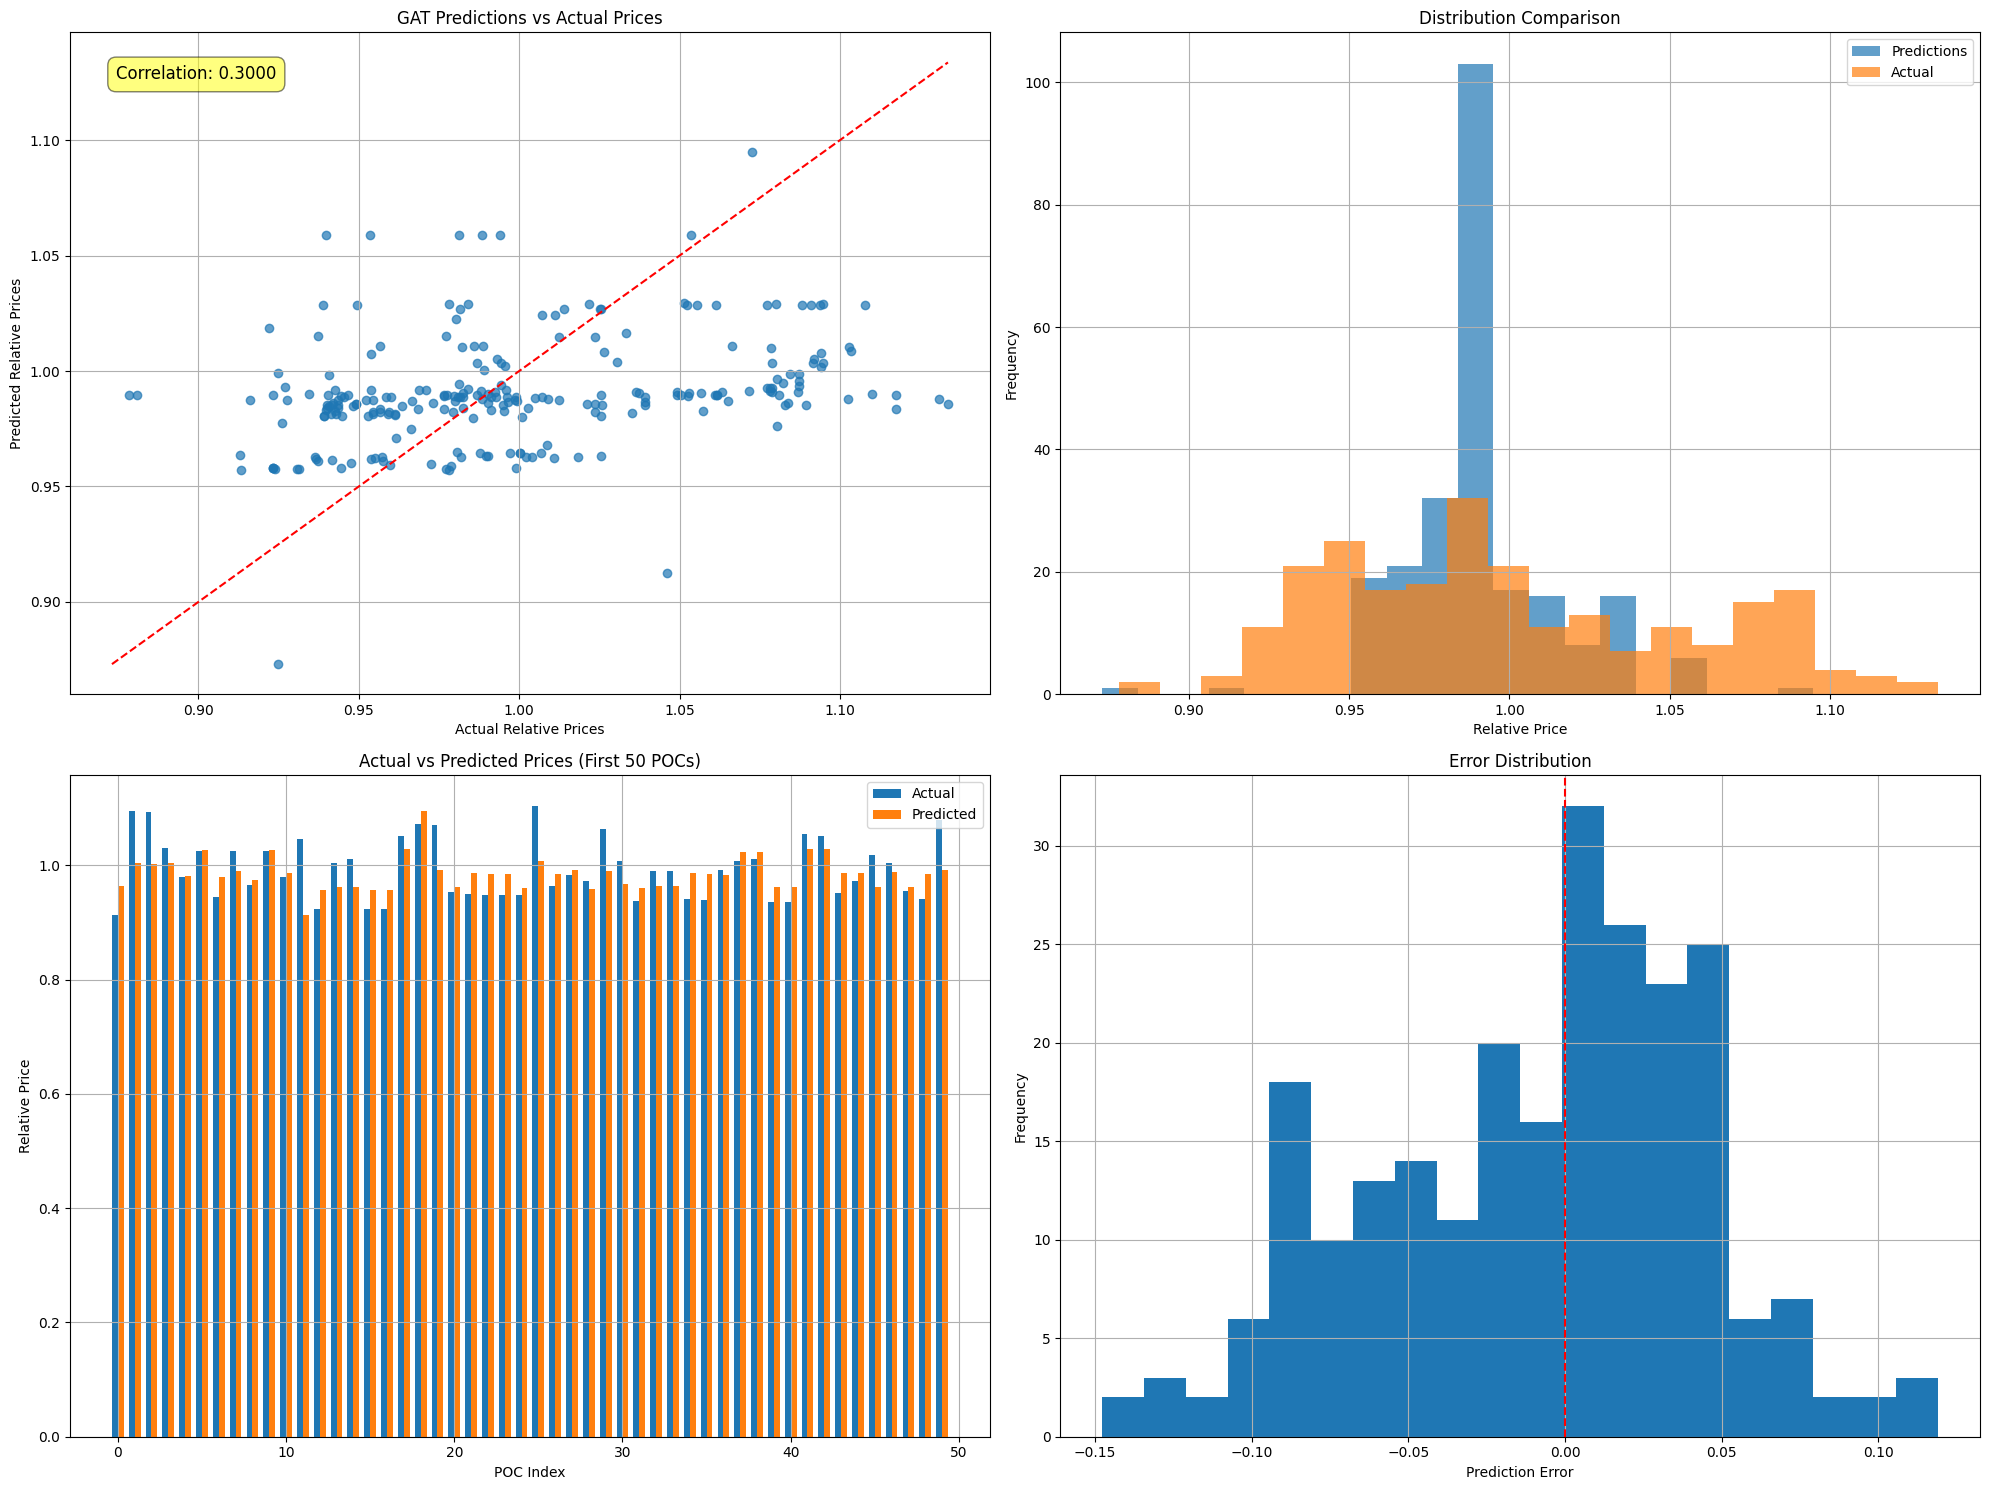


Top 10 Best Predictions:
      POC_ID    Actual  Predicted     Error
126  MNI0111  0.994377   0.994130  0.000247
129  MTI2201  0.988339   0.987919  0.000421
175  RPO2201  0.959762   0.959312  0.000449
172  ROT1101  0.990352   0.989864  0.000488
110  LFD1101  0.982503   0.983985  0.001482
74   HUI0331  0.992364   0.990735  0.001629
9    ASY0111  1.025369   1.027020  0.001650
5    ARG1101  1.025168   1.027020  0.001852
97   KIK0111  1.012489   1.014936  0.002446
224  WKM2201  0.991358   0.988810  0.002548

Top 10 Worst Predictions:
      POC_ID    Actual  Predicted     Error
193  TKA0331  0.880872   0.989558  0.108686
192  TKA0111  0.878255   0.989558  0.111303
225  WKO0331  1.102448   0.987944  0.114504
218  WGN0331  0.939637   1.058727  0.119090
104  KOE1101  1.110096   0.989864  0.120232
107  KPU0661  1.117542   0.989812  0.127729
11   ATU1101  1.046098   0.912659  0.133439
127  MPE1101  1.117542   0.983385  0.134156
217  WEL0331  1.130824   0.987755  0.143069
132  MTO0331  1.133642 

In [ ]:
def visualize_results(predictions_np, targets_np, valid_poc_ids=None):
    """
    Visualize the model results with detailed plots
    """
    if predictions_np is None or targets_np is None:
        print("Missing data for visualization")
        return

    try:
        # Create a figure with multiple plots for comprehensive evaluation
        plt.figure(figsize=(20, 15))

        # 1. Predictions vs Actual scatter plot
        plt.subplot(2, 2, 1)
        plt.scatter(targets_np, predictions_np, alpha=0.7)

        # Add perfect prediction line
        min_val = min(np.min(targets_np), np.min(predictions_np))
        max_val = max(np.max(targets_np), np.max(predictions_np))
        plt.plot([min_val, max_val], [min_val, max_val], 'r--')

        plt.xlabel('Actual Relative Prices')
        plt.ylabel('Predicted Relative Prices')
        plt.title('GAT Predictions vs Actual Prices')
        plt.grid(True)

        # Add correlation coefficient to plot
        corr = np.corrcoef(targets_np, predictions_np)[0, 1] if len(predictions_np) > 1 else 0
        plt.annotate(f'Correlation: {corr:.4f}', xy=(0.05, 0.95), xycoords='axes fraction',
                    fontsize=12, ha='left', va='top',
                    bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))

        # 2. Distribution comparison
        plt.subplot(2, 2, 2)
        plt.hist(predictions_np, bins=20, alpha=0.7, label='Predictions')
        plt.hist(targets_np, bins=20, alpha=0.7, label='Actual')
        plt.xlabel('Relative Price')
        plt.ylabel('Frequency')
        plt.title('Distribution Comparison')
        plt.legend()
        plt.grid(True)

        # 3. POC-wise predictions
        plt.subplot(2, 2, 3)
        sample_size = min(50, len(predictions_np))
        indices = np.arange(sample_size)
        width = 0.35
        plt.bar(indices - width/2, targets_np[:sample_size], width, label='Actual')
        plt.bar(indices + width/2, predictions_np[:sample_size], width, label='Predicted')
        plt.xlabel('POC Index')
        plt.ylabel('Relative Price')
        plt.title('Actual vs Predicted Prices (First 50 POCs)')
        plt.legend()
        plt.grid(True)

        # 4. Error distribution
        plt.subplot(2, 2, 4)
        errors = predictions_np - targets_np
        plt.hist(errors, bins=20)
        plt.xlabel('Prediction Error')
        plt.ylabel('Frequency')
        plt.title('Error Distribution')
        plt.axvline(x=0, color='r', linestyle='--')
        plt.grid(True)

        plt.tight_layout()
        plt.savefig('gat_evaluation_summary.png', dpi=300)
        plt.show()

        # If we have valid POC IDs, show top/bottom predictions
        if valid_poc_ids is not None and len(valid_poc_ids) == len(predictions_np):
            # Calculate error for each POC
            errors = np.abs(predictions_np - targets_np)

            # Create dataframe with results
            results_df = pd.DataFrame({
                'POC_ID': valid_poc_ids,
                'Actual': targets_np,
                'Predicted': predictions_np,
                'Error': errors
            })

            # Sort by error
            results_df = results_df.sort_values('Error')

            # Show top 10 best predictions
            print("\nTop 10 Best Predictions:")
            print(results_df.head(10))

            # Show top 10 worst predictions
            print("\nTop 10 Worst Predictions:")
            print(results_df.tail(10))

            # Save results to CSV
            results_df.to_csv('gat_prediction_results.csv', index=False)
            print("Prediction results saved to 'gat_prediction_results.csv'")

    except Exception as e:
        print(f"Error during visualization: {e}")

# Generate a summary report
def generate_summary_report():
    """
    Generate a comprehensive summary report of the GAT model performance
    """
    try:
        # Check if we have all the necessary data
        if 'gat_model' not in locals() or gat_model is None:
            print("Cannot generate report: model not available")
            return

        if 'predictions_np' not in locals() or predictions_np is None:
            print("Cannot generate report: predictions not available")
            return

        if 'targets_np' not in locals() or targets_np is None:
            print("Cannot generate report: targets not available")
            return

        # Create a report dataframe
        report = {
            'Model': ['Graph Attention Network (GAT)'],
            'Description': ['Spatial-Temporal Forecasting of Electricity Prices with Dynamic Graph Learning'],
            'Date': [datetime.now().strftime("%Y-%m-%d %H:%M:%S")],
            'Features': [', '.join([str(i) for i in range(node_features_matrix.shape[1])])],
            'Nodes': [len(valid_poc_ids) if valid_poc_ids else 'N/A'],
            'Edges': [sub_edge_index.shape[1] if sub_edge_index is not None else 'N/A'],
            'MSE': [F.mse_loss(torch.tensor(predictions_np), torch.tensor(targets_np)).item()],
            'RMSE': [np.sqrt(F.mse_loss(torch.tensor(predictions_np), torch.tensor(targets_np)).item())],
            'MAE': [F.l1_loss(torch.tensor(predictions_np), torch.tensor(targets_np)).item()],
            'R²': [max(0, 1 - np.sum((targets_np - predictions_np) ** 2) / np.sum((targets_np - np.mean(targets_np)) ** 2))],
            'Correlation': [np.corrcoef(targets_np, predictions_np)[0, 1] if len(predictions_np) > 1 else 0]
        }

        report_df = pd.DataFrame(report)

        # Save report to CSV
        report_df.to_csv('gat_model_report.csv', index=False)
        print("Summary report generated and saved to 'gat_model_report.csv'")

        # Display report
        print("\n======= GAT MODEL SUMMARY REPORT =======")
        for key, value in report.items():
            print(f"{key}: {value[0]}")
        print("========================================")

    except Exception as e:
        print(f"Error generating report: {e}")

# Visualize results and generate report
if 'predictions_np' in locals() and predictions_np is not None:
    visualize_results(predictions_np, targets_np, valid_poc_ids)
    generate_summary_report()
else:
    print("Cannot visualize results: predictions not available")